# Step-by-step radar adjustment

In this notebook we will do the following

1. Create synthetic example data with a true and perturbed (as observed by radar) rainfall field

2. Do step-by-step radar-gauge adjustment with different methods

3. Do step-by-step radar-CML adjustment with different methods

4. Introduce the high-level functions that combine the adjustment workflow into one function call

In [1]:
import sys

sys.path.append('../poligrain/src')
sys.path.append('../mergeplg/src')

import poligrain as plg
import mergeplg as mrg

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## Create synthetic example rainfall field and radar observation

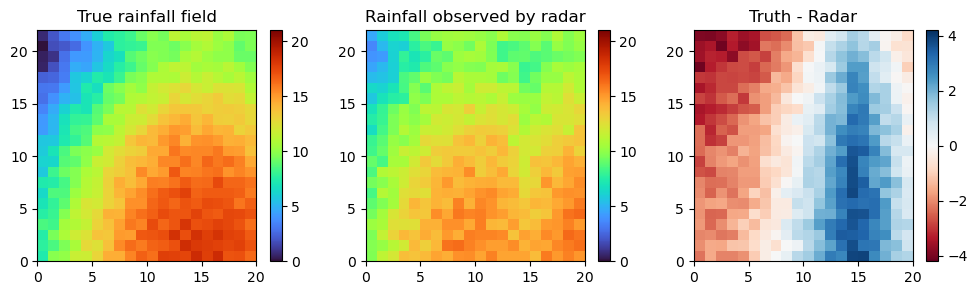

In [2]:
# grid axes
x = np.arange(0, 20)
y = np.arange(0, 22)
x_grid, y_grid = np.meshgrid(x, y)

np.random.seed(13196840)

# Synthetic true rainfall
truth = (
    np.abs(10.0 * np.sin(0.11 * x_grid))
    + np.abs(8.0 * np.cos(0.08 * y_grid))
    )
truth = truth + 0.8 * np.random.uniform(low=-1.0, high=1, size=x_grid.shape)
truth[truth < 0.0] = 0.0

# Creating radar data by perturbing truth
radar = truth.copy()
radar = 1.0 * truth + 0.5 * np.random.uniform(low=-1.0, high=1, size=x_grid.shape)
radar = (
    radar 
    + np.abs(6 * np.cos(0.11 * x_grid))
    - np.abs(3 * np.cos(0.06  * y_grid))
)
radar = radar - 1
radar[radar < 0.0] = 0.0

ds_radar = xr.Dataset(
    data_vars={
        'R_observed': ( ['y', 'x'], radar),
        'R_true': (['y',  'x'], truth),
    },
    coords={
        'x_grid': (['y', 'x'], x_grid),
        'y_grid':  (['y',   'x'], y_grid),
    },
)

vmin, vmax = 0, 21
cmap = 'turbo'
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].set_title('True rainfall field')
pc = axs[0].pcolormesh(truth, vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(pc)
axs[1].set_title('Rainfall observed by radar')
pc = axs[1].pcolormesh(radar, vmin=vmin, vmax=vmax, cmap=cmap)
plt.colorbar(pc)
axs[2].set_title('Truth - Radar')
pc = axs[2].pcolormesh(truth - radar, vmin=vmax * -0.2, vmax=vmax * 0.2, cmap='RdBu')
plt.colorbar(pc);

## Radar-gauge adjustment

### Create synthetic gauge observations

In [3]:
ds_gauges = xr.Dataset(
    data_vars={
        # dummy data, because we need gauge observations in GridAtPoints
        'R_init': (['id'], [0, 0, 0, 0]),
    },
    coords={
        'x': (('id'), [2, 16, 3, 6]),
        'y':  (['id'], [2, 5, 13, 6]),
        'lon': (('id'), [2, 16, 3, 6]),
        'lat':  (['id'], [2, 5, 13, 6]),
    },
)

In [4]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_radar,
    da_point_data=ds_gauges,
    nnear=1,
    use_lon_lat=False,
)

ds_gauges['R'] = get_grid_at_points(
    da_gridded_data=ds_radar.R_true,
    da_point_data=ds_gauges.R_init,
)
ds_gauges = ds_gauges.drop_vars('R_init')

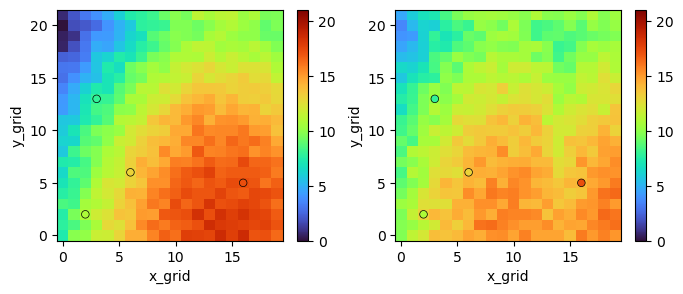

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_true, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=21,
    kwargs_gauges_plot={"s": 30},
    ax=axs[0],
)

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_observed, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=21,
    kwargs_gauges_plot={"s": 30},
    ax=axs[1],
);

### Additive adjustment with IDW interpolation

#### Calculate differencence between gauge data and radar data at gauge location

In [6]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_radar,
    da_point_data=ds_gauges,
    nnear=1,
    use_lon_lat=False,
)

ds_gauges['R_radar'] = get_grid_at_points(
    da_gridded_data=ds_radar.R_observed,
    da_point_data=ds_gauges.R,
)

ds_gauges['R_diff'] = ds_gauges.R - ds_gauges.R_radar

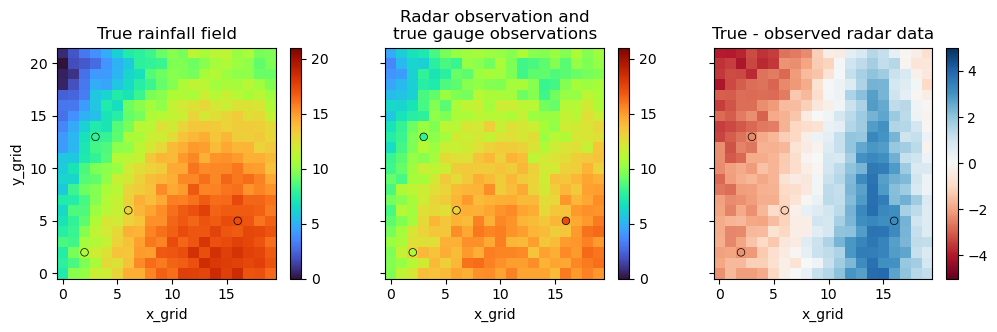

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_true, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=21,
    kwargs_gauges_plot={"s": 30},
    ax=axs[0],
)
axs[0].set_title('True rainfall field')

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_observed, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=21,
    kwargs_gauges_plot={"s": 30},
    ax=axs[1],
)
axs[1].set_title('Radar observation and\ntrue gauge observations')

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_true - ds_radar.R_observed, 
    da_gauges=ds_gauges.R_diff,
    use_lon_lat=False,
    vmin=-5,
    vmax=5,
    cmap='RdBu',
    kwargs_gauges_plot={"s": 30},
    ax=axs[2],
)
axs[2].set_title('True - observed radar data');
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[1].set_yticklabels([])
axs[2].set_yticklabels([]);

#### Spatial interpolation of differences

In [8]:
idw_interpolator = mrg.interpolate.InterpolateIDW(min_observations=2)

R_grid_idw = idw_interpolator.interpolate(
            da_grid=ds_radar,
            da_gauge=ds_gauges.R_diff,
            p=3,
            idw_method='standard',
        )

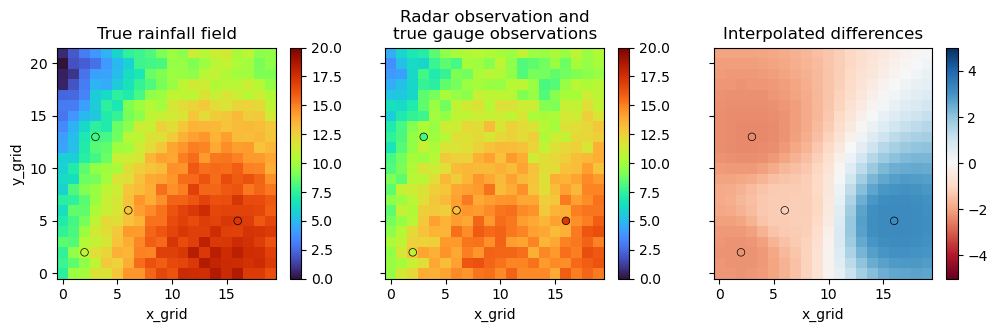

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_true, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[0],
)
axs[0].set_title('True rainfall field')


plg.plot_map.plot_plg(
    da_grid=ds_radar.R_observed, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=20,
    kwargs_gauges_plot={"s": 30},
    ax=axs[1],
)
axs[1].set_title('Radar observation and\ntrue gauge observations')

plg.plot_map.plot_plg(
    da_grid=R_grid_idw, 
    da_gauges=ds_gauges.R_diff,
    use_lon_lat=False,
    vmin=-5,
    vmax=5,
    cmap='RdBu',
    kwargs_gauges_plot={"s": 30},
    ax=axs[2],
)
axs[2].set_title('Interpolated differences')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[1].set_yticklabels([])
axs[2].set_yticklabels([]);

#### Adjust radar field with interpolated diff field

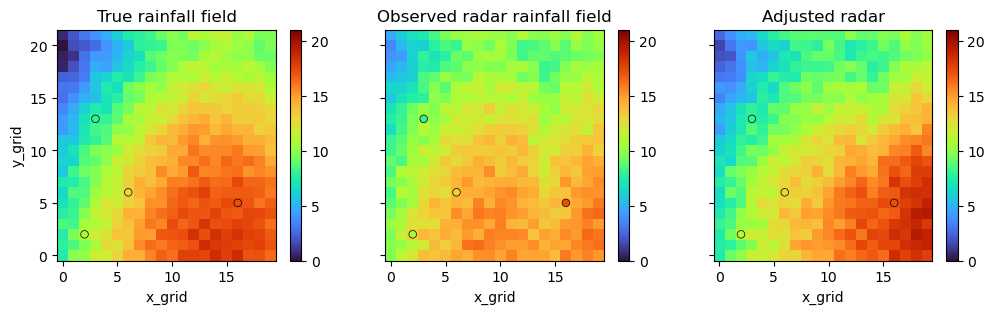

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_true, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=21,
    kwargs_gauges_plot={"s": 30},
    ax=axs[0],
)
axs[0].set_title('True rainfall field')

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_observed, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=21,
    kwargs_gauges_plot={"s": 30},
    ax=axs[1],
)
axs[1].set_title('Observed radar rainfall field')

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_observed + R_grid_idw, 
    da_gauges=ds_gauges.R,
    use_lon_lat=False,
    vmin=0,
    vmax=21,
    kwargs_gauges_plot={"s": 30},
    ax=axs[2],
)
axs[2].set_title('Adjusted radar')

axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[1].set_yticklabels([])
axs[2].set_yticklabels([]);

#### Define a function to plot all in one go

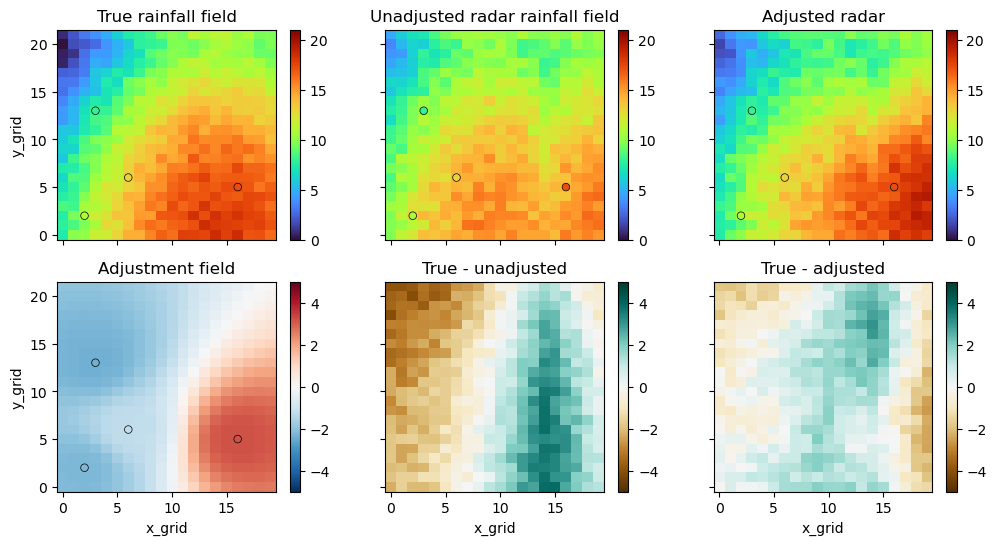

In [11]:
def plot_true_obs_adj_diff(
    da_grid_R_true,
    da_grid_R_observed,
    da_grid_R_adjusted,
    da_gauges_R=None,
    da_cmls_R=None,
    da_gauges_R_diff=None,
    da_cmls_R_diff=None,
    vmin=0,
    vmax=21,
    vmin_diff=-5,
    vmax_diff=5,
):

    fig, axs = plt.subplots(2, 3, figsize=(12, 6))

    plg.plot_map.plot_plg(
        da_grid=da_grid_R_true,
        da_gauges=da_gauges_R,
        da_cmls=da_cmls_R,
        use_lon_lat=False,
        vmin=vmin,
        vmax=vmax,
        kwargs_gauges_plot={"s": 30},
        ax=axs[0, 0],
    )
    axs[0, 0].set_title('True rainfall field')

    plg.plot_map.plot_plg(
        da_grid=da_grid_R_observed,
        da_gauges=da_gauges_R,
        da_cmls=da_cmls_R,
        use_lon_lat=False,
        vmin=vmin,
        vmax=vmax,
        kwargs_gauges_plot={"s": 30},
        ax=axs[0, 1],
    )
    axs[0, 1].set_title('Unadjusted radar rainfall field')

    plg.plot_map.plot_plg(
        da_grid=da_grid_R_adjusted,
        da_gauges=da_gauges_R,
        da_cmls=da_cmls_R,
        use_lon_lat=False,
        vmin=vmin,
        vmax=vmax,
        kwargs_gauges_plot={"s": 30},
        ax=axs[0, 2],
    )
    axs[0, 2].set_title('Adjusted radar')

    plg.plot_map.plot_plg(
        da_grid=da_grid_R_adjusted - da_grid_R_observed,
        da_gauges=da_gauges_R_diff,
        da_cmls=da_cmls_R_diff,
        use_lon_lat=False,
        vmin=vmin_diff,
        vmax=vmax_diff,
        cmap="RdBu_r",
        kwargs_gauges_plot={"s": 30},
        ax=axs[1, 0],
    )
    axs[1, 0].set_title('Adjustment field')

    plg.plot_map.plot_plg(
        da_grid=da_grid_R_true - da_grid_R_observed,
        use_lon_lat=False,
        vmin=vmin_diff,
        vmax=vmax_diff,
        cmap="BrBG",
        kwargs_gauges_plot={"s": 30},
        ax=axs[1, 1],
    )
    axs[1, 1].set_title('True - unadjusted')

    plg.plot_map.plot_plg(
        da_grid=da_grid_R_true - da_grid_R_adjusted,
        use_lon_lat=False,
        vmin=vmin_diff,
        vmax=vmax_diff,
        cmap="BrBG",
        kwargs_gauges_plot={"s": 30},
        ax=axs[1, 2],
    )
    axs[1, 2].set_title('True - adjusted')

    for i in [0, 1]:
        axs[i, 1].set_ylabel('')
        axs[i, 2].set_ylabel('')
        axs[i, 1].set_yticklabels([])
        axs[i, 2].set_yticklabels([])
    for j in [0, 1, 2]:
        axs[0, j].set_xlabel('')
        axs[0, j].set_xticklabels([])


plot_true_obs_adj_diff(
    da_grid_R_true=ds_radar.R_true,
    da_grid_R_observed=ds_radar.R_observed,
    da_grid_R_adjusted=ds_radar.R_observed + R_grid_idw,
    da_gauges_R=ds_gauges.R,
    da_gauges_R_diff=ds_gauges.R_diff,
)

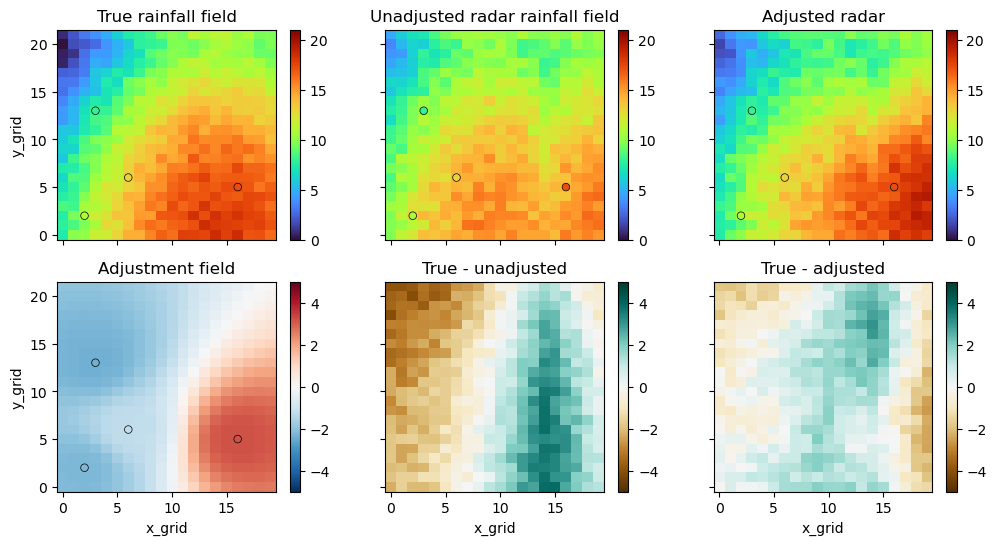

In [12]:
idw_interpolator = mrg.interpolate.InterpolateIDW(min_observations=2)

R_grid_idw = idw_interpolator.interpolate(
            da_grid=ds_radar,
            da_gauge=ds_gauges.R_diff,
            p=3,
            idw_method='standard',
        )

plot_true_obs_adj_diff(
    da_grid_R_true=ds_radar.R_true,
    da_grid_R_observed=ds_radar.R_observed,
    da_grid_R_adjusted=ds_radar.R_observed + R_grid_idw,
    da_gauges_R=ds_gauges.R,
    da_gauges_R_diff=ds_gauges.R_diff,
)

### Additive adjustment with Ordinary Kriging interpolation

Here we reuse the differencence between radar and gauge that we already calculated above.

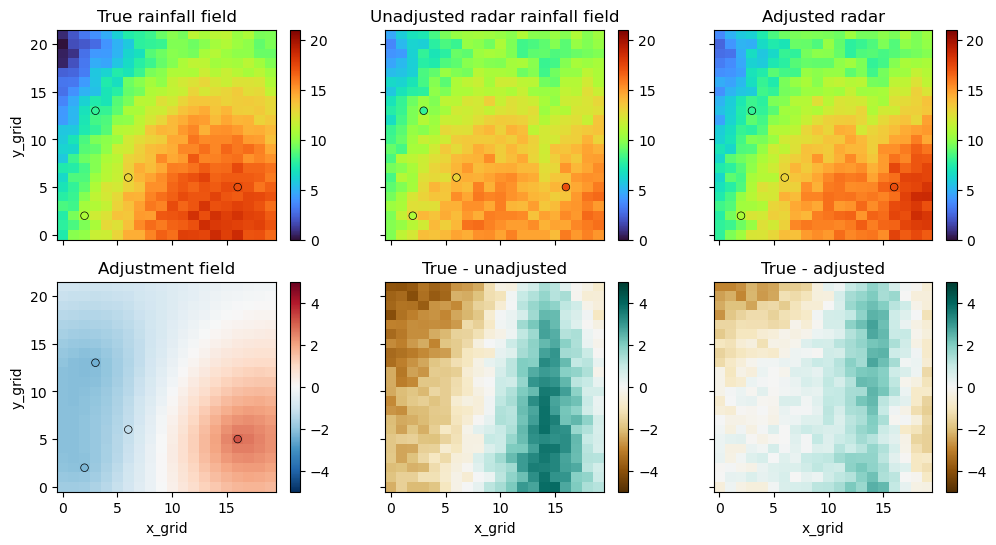

In [13]:
ok_interpolator = mrg.interpolate.InterpolateOrdinaryKriging(min_observations=2)

R_grid_idw = ok_interpolator.interpolate(
    da_grid=ds_radar,
    da_gauge=ds_gauges.R_diff,
    variogram_parameters = {"sill": 1, "range": 20, "nugget": 0.1}
)

plot_true_obs_adj_diff(
    da_grid_R_true=ds_radar.R_true,
    da_grid_R_observed=ds_radar.R_observed,
    da_grid_R_adjusted=ds_radar.R_observed + R_grid_idw,
    da_gauges_R=ds_gauges.R,
    da_gauges_R_diff=ds_gauges.R_diff,
)

### Ex 1: Play with different variants of radar-gauge adjustment

- Ex1.1: Change IDW parameteres and change the Kriging variogram parameters. You can reuse the code from above. Look at the results. What are "good" parameteres?
- Ex1.2: Do multiplicative adjustment insteand of additive adjustment. Plot the results and try variations of the parameters.

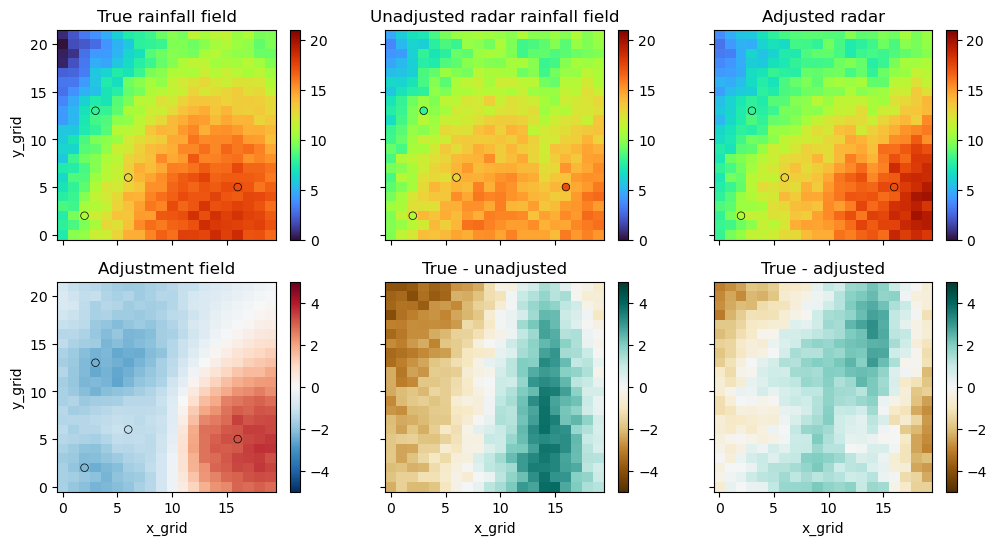

In [14]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_radar,
    da_point_data=ds_gauges,
    nnear=1,
    use_lon_lat=False,
)

ds_gauges['R_radar'] = get_grid_at_points(
    da_gridded_data=ds_radar.R_observed,
    da_point_data=ds_gauges.R,
)

ds_gauges['R_fact'] = ds_gauges.R / ds_gauges.R_radar

idw_interpolator = mrg.interpolate.InterpolateIDW(min_observations=2)

R_grid_idw = idw_interpolator.interpolate(
            da_grid=ds_radar,
            da_gauge=ds_gauges.R_fact,
            p=3,
            idw_method='standard',
        )

plot_true_obs_adj_diff(
    da_grid_R_true=ds_radar.R_true,
    da_grid_R_observed=ds_radar.R_observed,
    da_grid_R_adjusted=ds_radar.R_observed * R_grid_idw,
    da_gauges_R=ds_gauges.R,
    da_gauges_R_diff=ds_gauges.R_diff,
)

## Radar-CML adjustment

### Create synthetic CML observations

In [15]:
site_0_x = [19, 2, 2, 12]
site_0_y = [8, 10, 10, 14]
site_1_x = [9, 4, 3, 12.4]
site_1_y = [6, 6.2, 0.3, 14.3]

cml_ids = [f'cml{i}' for i in range(len(site_0_x))]

ds_cmls = xr.Dataset(
    coords={
        'site_0_lon': (["cml_id"], site_0_x),
        'site_1_lon': (["cml_id"], site_1_x),
        'site_0_lat': (["cml_id"], site_0_y),
        'site_1_lat': (["cml_id"], site_1_y),
        'site_0_x': (["cml_id"], site_0_x),
        'site_1_x': (["cml_id"], site_1_x),
        'site_0_y': (["cml_id"], site_0_y),
        'site_1_y': (["cml_id"], site_1_y),
    },
)

ds_cmls

<xarray.Dataset> Size: 256B
Dimensions:     (cml_id: 4)
Coordinates:
    site_0_lon  (cml_id) int64 32B 19 2 2 12
    site_1_lon  (cml_id) float64 32B 9.0 4.0 3.0 12.4
    site_0_lat  (cml_id) int64 32B 8 10 10 14
    site_1_lat  (cml_id) float64 32B 6.0 6.2 0.3 14.3
    site_0_x    (cml_id) int64 32B 19 2 2 12
    site_1_x    (cml_id) float64 32B 9.0 4.0 3.0 12.4
    site_0_y    (cml_id) int64 32B 8 10 10 14
    site_1_y    (cml_id) float64 32B 6.0 6.2 0.3 14.3
Dimensions without coordinates: cml_id
Data variables:
    *empty*

In [16]:
get_grid_at_lines = plg.spatial.GridAtLines(
    da_gridded_data=ds_radar,
    ds_line_data=ds_cmls,
)

ds_cmls['R'] = get_grid_at_lines(da_gridded_data=ds_radar.R_true)
ds_cmls['R_radar'] = get_grid_at_lines(da_gridded_data=ds_radar.R_observed)
ds_cmls['R_diff'] = ds_cmls.R - ds_cmls.R_radar

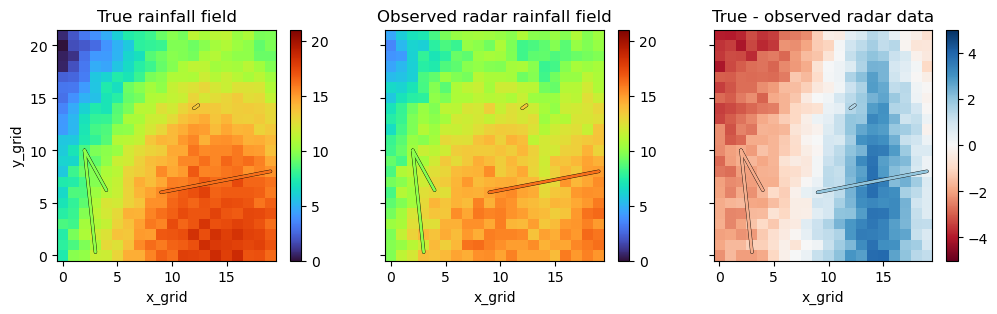

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_true, 
    da_cmls=ds_cmls.R,
    use_lon_lat=False,
    vmin=0,
    vmax=21,
    kwargs_gauges_plot={"s": 30},
    ax=axs[0],
)
axs[0].set_title('True rainfall field')


plg.plot_map.plot_plg(
    da_grid=ds_radar.R_observed, 
    da_cmls=ds_cmls.R,
    use_lon_lat=False,
    vmin=0,
    vmax=21,
    kwargs_gauges_plot={"s": 30},
    ax=axs[1],
)
axs[1].set_title('Observed radar rainfall field')

plg.plot_map.plot_plg(
    da_grid=ds_radar.R_true - ds_radar.R_observed, 
    da_cmls=ds_cmls.R_diff,
    use_lon_lat=False,
    vmin=-5,
    vmax=5,
    cmap='RdBu',
    kwargs_gauges_plot={"s": 30},
    ax=axs[2],
)
axs[2].set_title('True - observed radar data')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[1].set_yticklabels([])
axs[2].set_yticklabels([]);

### Additive adjustment with IDW interpolation

We have already calculated the diff of radar and CML above. Now we just have to interpolat the diff field. For IDW, we have to represent each CML path by a synthetic gauge in the middle of its path. This is automatically done in `InterpolateIDW`.

In [18]:
idw_interpolator = mrg.interpolate.InterpolateIDW(min_observations=2)

R_grid_idw = idw_interpolator.interpolate(
            da_grid=ds_radar,
            da_cml=ds_cmls.R_diff,
            p=3,
            idw_method='standard',
        )

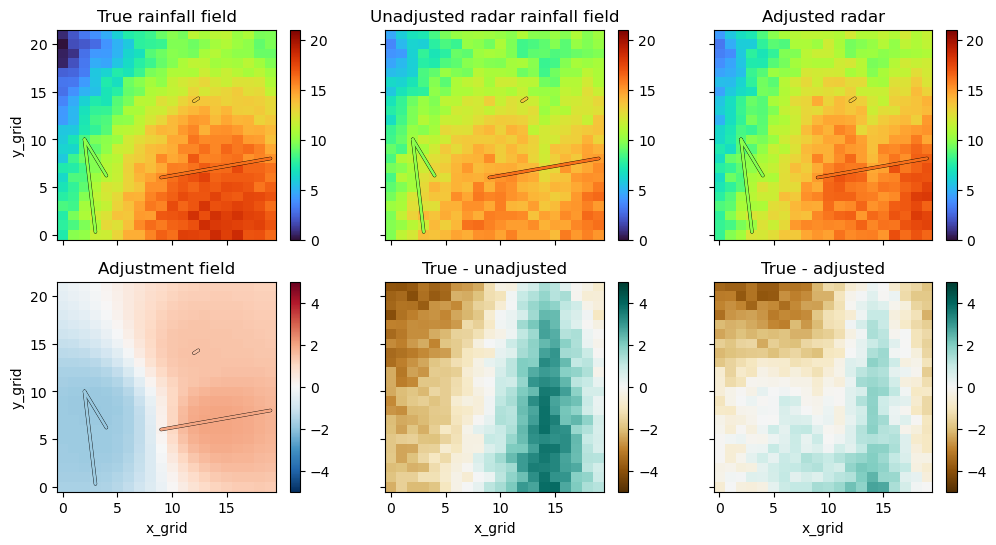

In [19]:
plot_true_obs_adj_diff(
    da_grid_R_true=ds_radar.R_true,
    da_grid_R_observed=ds_radar.R_observed,
    da_grid_R_adjusted=ds_radar.R_observed + R_grid_idw,
    da_cmls_R=ds_cmls.R,
    da_cmls_R_diff=ds_cmls.R_diff,
)

### Ex2: Use Kriging with CMLs

- Ex2.1: Use Ordinary Kriging for interpolating CML adjustment field and plot the result.
- Ex2.2: Switch on/off `full_line` option in `.interpolate()`. Experiment with the variogram parameteres. Plot the results of both variants compared to IDW. What do you observe?

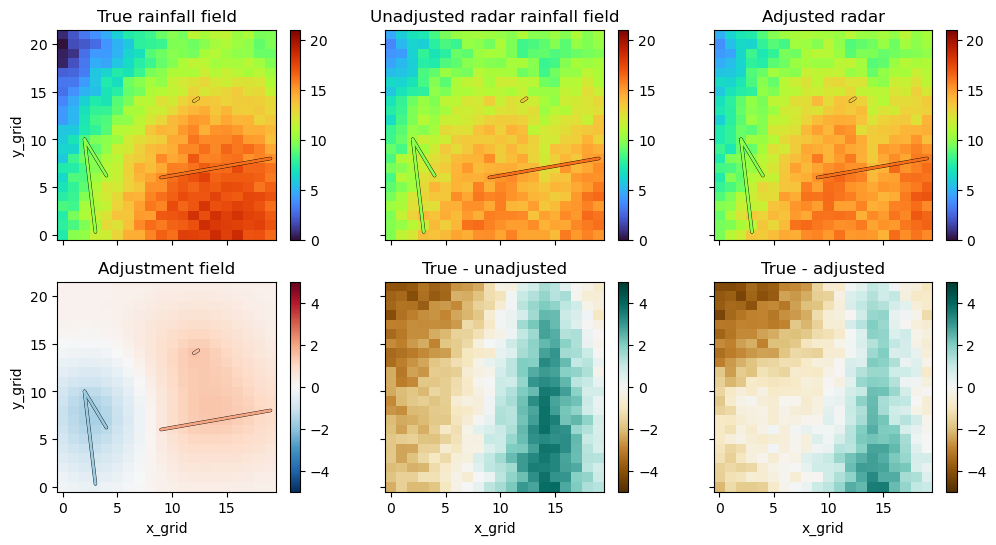

In [20]:
# Solution Ex2.1

R_grid_ok = ok_interpolator.interpolate(
            da_grid=ds_radar,
            da_cml=ds_cmls.R_diff,
            variogram_parameters = {"sill": 1, "range": 10, "nugget": 0.01},
        )

plot_true_obs_adj_diff(
    da_grid_R_true=ds_radar.R_true,
    da_grid_R_observed=ds_radar.R_observed,
    da_grid_R_adjusted=ds_radar.R_observed + R_grid_ok,
    da_cmls_R=ds_cmls.R,
    da_cmls_R_diff=ds_cmls.R_diff,
)

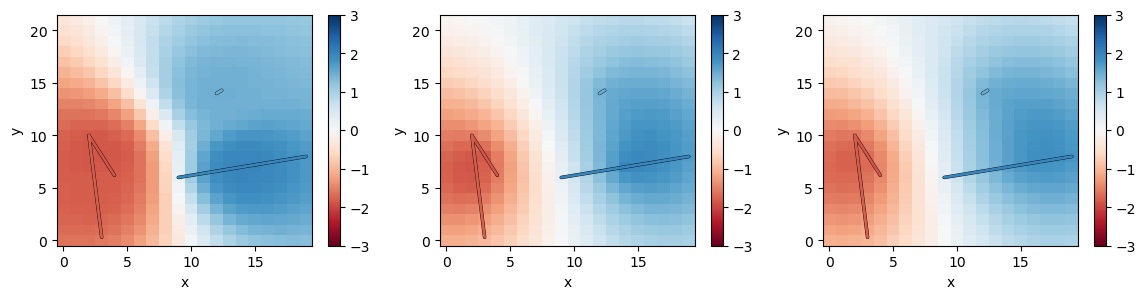

In [21]:
# solution Ex2.2 combined

ok_interpolator = mrg.interpolate.InterpolateOrdinaryKriging(min_observations=2, discretization=8)

R_grid_idw = idw_interpolator.interpolate(
            da_grid=ds_radar,
            da_cml=ds_cmls.R_diff,
            p=3,
            idw_method='standard',
        )

R_grid_ok = ok_interpolator.interpolate(
            da_grid=ds_radar,
            da_cml=ds_cmls.R_diff,
            variogram_parameters = {"sill": 1, "range": 20, "nugget": 0.01},
            full_line=False,
        )

R_grid_ok_block = ok_interpolator.interpolate(
            da_grid=ds_radar,
            da_cml=ds_cmls.R_diff,
            variogram_parameters = {"sill": 1, "range": 20, "nugget": 0.01},
            full_line=True,
        )

vmin, vmax = -3, 3
fig, axs = plt.subplots(1, 3, figsize=(14, 3))
R_grid_idw.plot(ax=axs[0], vmin=vmin, vmax=vmax, cmap='RdBu')
R_grid_ok.plot(ax=axs[1], vmin=vmin, vmax=vmax, cmap='RdBu')
R_grid_ok_block.plot(ax=axs[2], vmin=vmin, vmax=vmax, cmap='RdBu')
for i in [0, 1, 2]:
    plg.plot_map.plot_plg(da_cmls=ds_cmls.R_diff, ax=axs[i], vmin=vmin, vmax=vmax, cmap='RdBu', add_colorbar=False)


## Introduction to high-level merging functions

In `mergeplg` there are high-level functions that combine the three steps of the radar adjustment process we did above:
1. caclulating the difference between radar and gauges or CMLs
2. interpolate the adjustment field
3. adjust the radar field

We will use `MergeDifferenceIDW` and `MergeDifferenceOrdinaryKriging` below.

In addition there is also a high-level function `MergeKrigingExternalDrift` which follows a different approach. We will show this at the end of this noteobook.

### usage of `MergeDifferenceIDW`

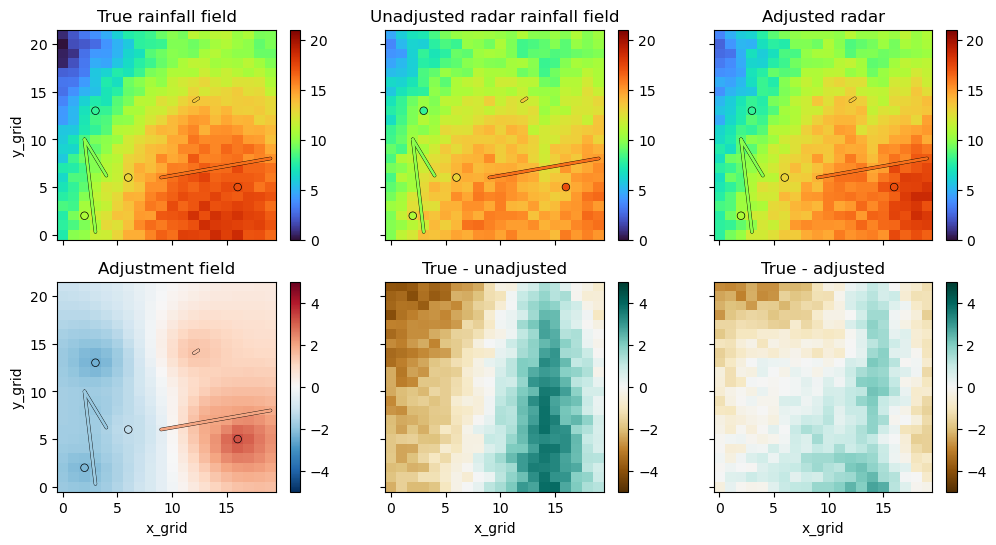

In [22]:
merger = mrg.merge.MergeDifferenceIDW(min_observations=3)

R_grid_idw_high_level = merger.adjust(
    ds_radar.R_observed,
    da_cml=ds_cmls.R,
    da_gauge=ds_gauges.R,
    idw_method="standard",
    max_distance=50,
)

plot_true_obs_adj_diff(
    da_grid_R_true=ds_radar.R_true,
    da_grid_R_observed=ds_radar.R_observed,
    da_grid_R_adjusted=R_grid_idw_high_level,
    da_cmls_R=ds_cmls.R,
    da_gauges_R=ds_gauges.R,
    da_cmls_R_diff=ds_cmls.R_diff,
    da_gauges_R_diff=ds_gauges.R_diff,
)

### usage of `MergeDifferenceOrdinaryKriging`

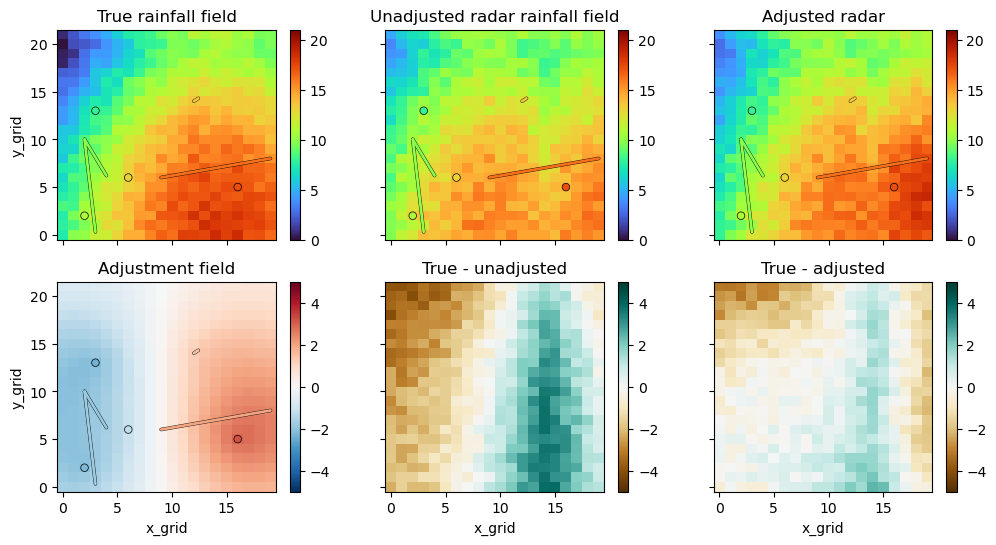

In [23]:
merger = mrg.merge.MergeDifferenceOrdinaryKriging(min_observations=3)

R_grid_ok_high_level = merger.adjust(
    ds_radar.R_observed,
    da_cml=ds_cmls.R,
    da_gauge=ds_gauges.R,
    variogram_parameters = {"sill": 1, "range": 20, "nugget": 0.1}
)

plot_true_obs_adj_diff(
    da_grid_R_true=ds_radar.R_true,
    da_grid_R_observed=ds_radar.R_observed,
    da_grid_R_adjusted=R_grid_ok_high_level,
    da_cmls_R=ds_cmls.R,
    da_gauges_R=ds_gauges.R,
    da_cmls_R_diff=ds_cmls.R_diff,
    da_gauges_R_diff=ds_gauges.R_diff,
)

### Usage of `MergeKrigingExternalDrift`

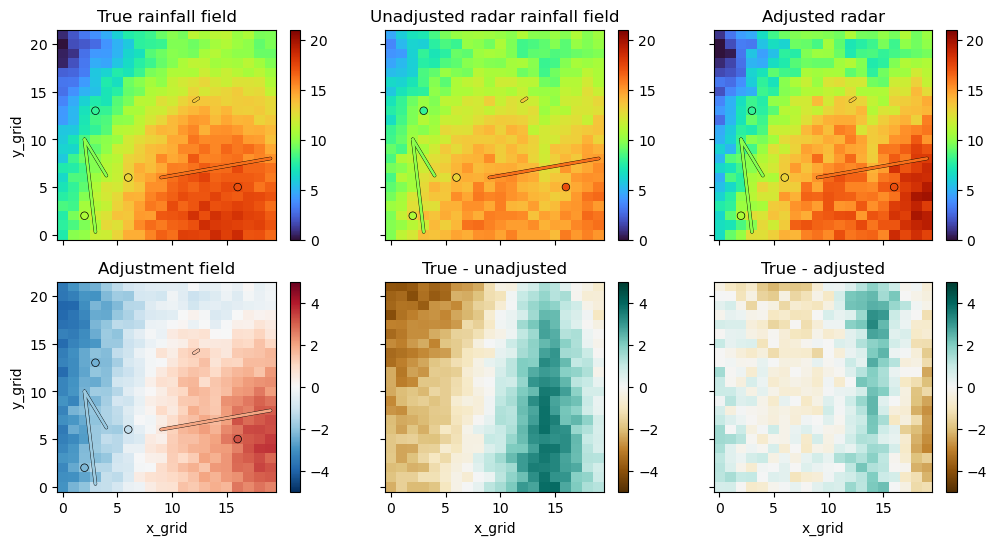

In [24]:
merger = mrg.merge.MergeKrigingExternalDrift(min_observations=3)

R_grid_ked_high_level = merger.adjust(
    da_rad=ds_radar.R_observed,#.expand_dims('time').sel(time=[0]), # TODO, remove .sel once mergeplg is updated
    da_cml=ds_cmls.R,#.expand_dims('time'),
    da_gauge=ds_gauges.R.expand_dims('time'),
    variogram_parameters = {"sill": 1, "range": 20, "nugget": 0.1}
)#.isel(time=0)

plot_true_obs_adj_diff(
    da_grid_R_true=ds_radar.R_true,
    da_grid_R_observed=ds_radar.R_observed,
    da_grid_R_adjusted=R_grid_ked_high_level,
    da_cmls_R=ds_cmls.R,
    da_gauges_R=ds_gauges.R,
    da_cmls_R_diff=ds_cmls.R_diff,
    da_gauges_R_diff=ds_gauges.R_diff,
)

### Ex3: Compare the different methods
- 3.1: Create a scatter or hexbin plot of the different adjusted fields vs the true rainfall field. You can also create more adjusted fields with different variations of the methods (gauge only, CML only, multiplicative instead of additive, different parameters)
- 3.2 (optional): Calculate some metrics. You can use `plg.validation.calculate_rainfall_metrics`.

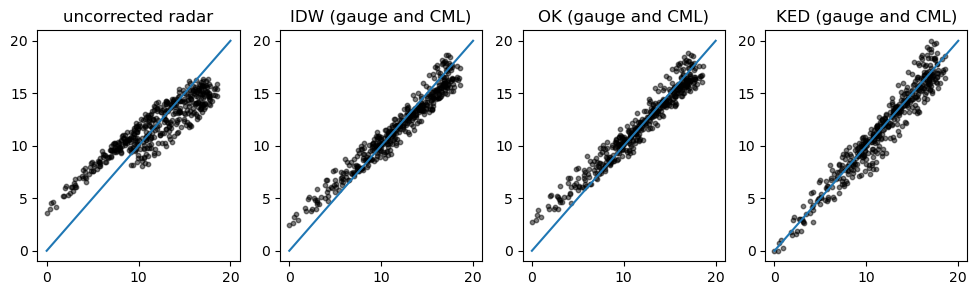

In [25]:
# Solution 3.1

R_product_dict = {
    'uncorrected radar': ds_radar.R_observed,
    'IDW (gauge and CML)': R_grid_idw_high_level,
    'OK (gauge and CML)': R_grid_ok_high_level,
    'KED (gauge and CML)': R_grid_ked_high_level,
}

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, (product_name, R_product) in enumerate(R_product_dict.items()):
    axs[i].scatter(
        ds_radar.R_true.data.flatten(), 
        R_product.data.flatten(),
        c='k',
        alpha=0.5,
        s=10,
    )
    axs[i].plot([0, 20], [0, 20])
    axs[i].set_title(product_name)

/Users/chwala-c/code/TrainingSchoolMergingApplication/os-merging-session/../poligrain/src/poligrain/validation.py:193: RuntimeWarning: Mean of empty slice.
  FN_r_mean = reference[reference_wet & estimate_dry].mean()
/Users/chwala-c/miniforge3/envs/prepep_os_processing/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/chwala-c/code/TrainingSchoolMergingApplication/os-merging-session/../poligrain/src/poligrain/validation.py:192: RuntimeWarning: Mean of empty slice.
  FP_r_mean = estimate[reference_dry & estimate_wet].mean()


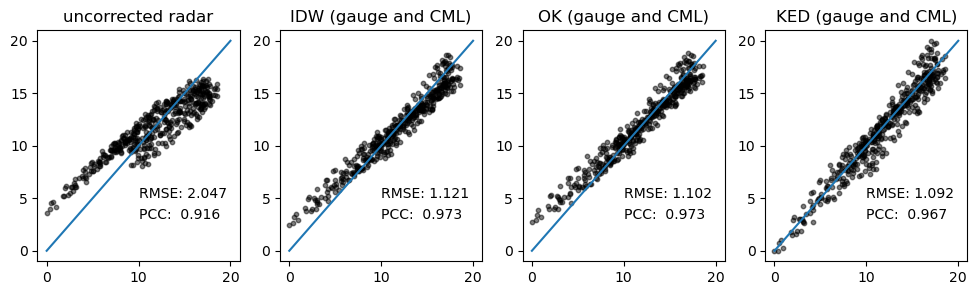

In [26]:
# Solution 3.2

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, (product_name, R_product) in enumerate(R_product_dict.items()):
    axs[i].scatter(
        ds_radar.R_true.data.flatten(), 
        R_product.data.flatten(),
        c='k',
        alpha=0.5,
        s=10,
    )
    axs[i].plot([0, 20], [0, 20])
    axs[i].set_title(product_name)

    metrics = plg.validation.calculate_rainfall_metrics(
        ds_radar.R_true.data.flatten(),
        R_product.data.flatten()
    )
    axs[i].text(10, 5, f"RMSE: {metrics['root_mean_square_error']:0.3f}")
    axs[i].text(10, 3, f"PCC:  {metrics['pearson_correlation_coefficient']:0.3f}")